In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from chromalab.observer import Observer, Cone, transformToChromaticity, getHeringMatrix
from chromalab.inks import Neugebauer, InkGamut, CellNeugebauer, Pigment, InkLibrary
from chromalab.spectra import Spectra, Illuminant
from chromalab.maxbasis import MaxBasis
from chromalab.cubemap import CubeMap
from chromalab.printer import Printer

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

In [2]:
wavelengths10 = np.arange(400, 701, 10)
cmy_primaries_dict = {}
with open(f'../data/nix/PrintColors/000.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i == 4:
            color_data = np.array(row[33:],dtype=float)
            spectra = Spectra(data=color_data, wavelengths=wavelengths10)
            cmy_primaries_dict["000"] = spectra

paper = cmy_primaries_dict["000"]
d65 = Illuminant.get("d65")
wavelengths = np.arange(390, 700, 10)

In [3]:
cellneug = {}
with open(f'../data/nix/28cellNB.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i < 4: continue            
        name = row[4]
        color_data = np.array(row[33:],dtype=float)
        spectra = Spectra(data=color_data, wavelengths=wavelengths10)
        cellneug[name] = spectra

neugebauer = CellNeugebauer(cellneug)
gamut = InkGamut(neugebauer, paper, d65)

/Users/jessicalee/Projects/generalized-colorimetry/code/ChromaLab/chromalab/spectra.py:36: UserWarning: Data has values not between 0 and 1. Clipping.
  warnings.warn("Data has values not between 0 and 1. Clipping.")


In [4]:
tetrachromat = Observer.tetrachromat(wavelengths=wavelengths, illuminant=d65, verbose=True) 
maxbasis = MaxBasis(tetrachromat, verbose=True)
tetra_maxbasis = maxbasis.get_max_basis_observer()

100%|██████████| 28/28 [00:00<00:00, 64.44it/s]


In [5]:
buckets = gamut.get_buckets_in_hering(maxbasis, 2, 0.05)

Generating point cloud: 2it [00:00,  4.73it/s]                       
Generating point cloud: 2it [00:00,  4.86it/s]                       
Generating point cloud: 2it [00:00,  5.10it/s]                       
Generating point cloud: 2it [00:00,  4.33it/s]                       
Generating point cloud: 2it [00:00,  4.79it/s]                       
Generating point cloud: 2it [00:00,  4.99it/s]                       
Generating point cloud: 2it [00:00,  5.03it/s]                       
Generating point cloud: 2it [00:00,  4.75it/s]                       
Generating point cloud: 2it [00:00,  4.83it/s]                       
Generating point cloud: 2it [00:00,  4.51it/s]                       
Generating point cloud: 2it [00:00,  5.29it/s]                       
Generating point cloud: 2it [00:00,  4.87it/s]                       
Generating point cloud: 2it [00:00,  5.30it/s]                       
Generating point cloud: 2it [00:00,  5.22it/s]                       
Generating point clo

Point cloud generated.


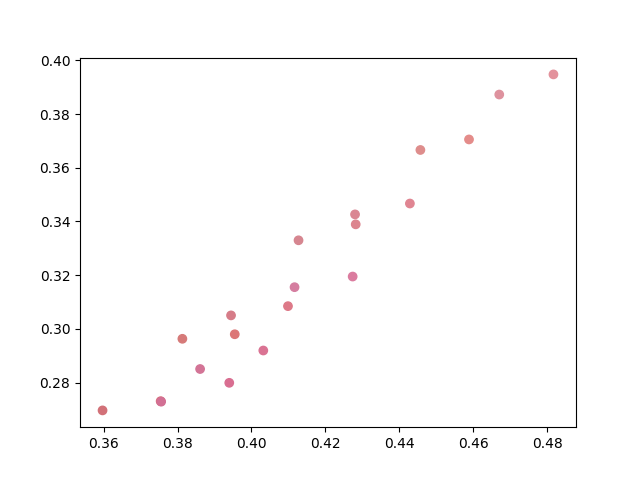

[((0.0, 0.65000000000000002, 0.0, 0.69999999999999996, 0.050000000000000003), (0.80000000000000004, 0.0, 0.0, 0.050000000000000003, 0.90000000000000002)), ((0.0, 0.69999999999999996, 0.0, 0.94999999999999996, 0.0), (1.0, 0.0, 0.050000000000000003, 0.55000000000000004, 0.90000000000000002)), ((0.0, 0.65000000000000002, 0.0, 0.94999999999999996, 0.0), (0.90000000000000002, 0.0, 0.050000000000000003, 0.59999999999999998, 0.85000000000000009)), ((0.0, 0.59999999999999998, 0.0, 0.80000000000000004, 0.0), (0.75, 0.0, 0.0, 0.40000000000000002, 0.85000000000000009)), ((0.050000000000000003, 0.55000000000000004, 0.0, 0.85000000000000009, 0.0), (0.69999999999999996, 0.0, 0.0, 0.55000000000000004, 0.80000000000000004)), ((0.0, 0.69999999999999996, 0.0, 0.75, 0.0), (0.90000000000000002, 0.0, 0.5, 0.20000000000000001, 0.30000000000000004)), ((0.0, 0.65000000000000002, 0.0, 0.85000000000000009, 0.0), (0.85000000000000009, 0.0, 0.40000000000000002, 0.55000000000000004, 0.45000000000000001)), ((0.0, 0

In [6]:
colors = []
xys = []
percs = []
for i in range(0, 10):
    # fig = plt.figure()
    # print(buckets[i][0])
    for j in range(2):
        spectra = gamut.get_spectra(buckets[i][1][j])
        xys += [spectra.to_xyz(d65)[:2]]
        colors += [spectra.to_rgb(d65)]
        # print(tetrachromat.observe(spectra))
        # spectra.plot()
    percs += [buckets[i][1]]
    # plt.title(f'Index {i}')
    # plt.show()
xys = np.array(xys)
fig = plt.figure()
plt.scatter(xys[:, 0], xys[:, 1], c=colors)
plt.show()

print(percs)

In [7]:
def BackupPrinterMap(c):
    return [(0,c[1],0,0),
            (c[2],0,c[3],0),
            (0,c[0],0,0),
            (0,0,c[4],0)]
backupPrinterNames = ["V","TC","R","M"]

p = Printer(printerMap=BackupPrinterMap, printerNames=backupPrinterNames, directory='../../chromalab')

testDict = {
    "A": (percs[0][0],percs[0][1],'87'), #downstairs
    "B": (percs[1][0],percs[1][1],'85')
}

for t in testDict.keys():
    inside,outside,secret = testDict[t]
    print(inside)
    # inside = p.CIJKtoCMYIJK(p.div100(inside)) #if the printer values are out of 1, or are 6d, you can skip those steps
    # outside = p.CIJKtoCMYIJK(p.div100(outside))
    print(inside)
    print(outside)
    p.generate_CC(inside,outside,0,secret,t,True)

(0.0, 0.65000000000000002, 0.0, 0.69999999999999996, 0.050000000000000003)
(0.0, 0.65000000000000002, 0.0, 0.69999999999999996, 0.050000000000000003)
(0.80000000000000004, 0.0, 0.0, 0.050000000000000003, 0.90000000000000002)
18
24
20
25
18
24
24
24
14
24
13
25
12
24
12
25
20
26
20
13
19
20
12
24
14
20
13
25
13
26
20
24
19
18
12
18
25
20
13
13
25
24
24
12
20
26
20
14
13
12
18
19
19
12
12
20
26
25
18
24
14
20
24
25
20
12
25
24
18
24
25
13
18
24
25
18
24
25
26
19
26
20
19
14
24
25
26
14
13
25
18
20
19
14
20
20
19
18
26
13
20
18
26
12
13
13
19
20
24
14
24
19
14
25
19
12
24
12
20
25
14
18
18
24
13
13
12
13
25
14
14
18
18
19
14
20
24
14
19
26
14
24
14
12
24
20
18
25
24
24
26
20
24
18
24
19
26
19
14
14
13
25
26
14
13
13
14
25
24
20
25
24
14
20
13
12
19
13
24
25
20
12
13
19
25
26
26
12
12
26
24
26
26
13
24
19
14
12
25
26
14
19
13
13
18
24
19
19
26
24
19
12
12
18
14
19
25
19
20
26
26
19
12
26
24
26
20
20
25
20
13
14
14
12
14
20
18
14
13
20
13
20
25
14
12
20
19
26
14
14
19
13
20
26
20
24
12
14
1